In [95]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import sympy as sp
from scipy.special import erf
from scipy.integrate import quad
from scipy.fft import dst
import networkx as nx
import math
import torch

from utils import *
from intersection_graph import *

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc('text', usetex=False)

In [ ]:
def optimise_vanishing_set(phi, dphi, n=10, seed=0, steps=2000, lr=0.1, tol=1e-6):
    """
    Projected gradient descent on the unit sphere S^{n-1} to approximate a
    vanishing direction x (i.e. where h(x) = <x, phi(x)> ≈ 0).

    We minimise J(x) = 0.5 * h(x)^2 subject to ||x|| = 1.
    The cone structure of V_f (scale-invariant) means it suffices to search
    for directions on the sphere instead of all R^n.
    """

    rng = np.random.default_rng(seed)
    x = rng.normal(size=n)
    x /= np.linalg.norm(x)   # start on unit sphere S^{n-1}

    # h(x) = <x, f(x)> = Σ x_i φ(x_i).  Vanishes exactly on V_f.
    def h(x): return float(np.dot(x, phi(x)))

    # ∇h(x) = φ(x) + φ'(x) * x
    def grad_h(x): return phi(x) + dphi(x) * x

    # Project v onto tangent space of sphere at x: (I - xx^T)v.
    def proj_tangent(x, v): return v - x * np.dot(x, v)

    # step along tangent then renormalise back to S^{n-1}.
    def step_on_sphere(x, g, eta):
        y = x - eta * g
        return y / np.linalg.norm(y)

    hx_hist = []

    for k in range(steps):
        hx = h(x)
        hx_hist.append(abs(hx))
        if abs(hx) <= tol:          # convergence
            return x, hx, hx_hist

        g_euc = grad_h(x)           # Euclidean gradient of h
        # Riemannian gradient of J = 0.5 h^2: grad_S J = h * (proj tangent ∇h)
        g_sph = hx * proj_tangent(x, g_euc)
        x = step_on_sphere(x, g_sph, lr)

    return x, h(x), hx_hist


# ---------------- visualisation (2D only) ----------------

def plot_vanishing_set(phi, dphi, name="activation", n_points=400, eps=1e-8, seed=0):
    """
    Visualise:
      1. h(x) values on the unit circle S¹ with trajectory of optimisation
      2. Convergence plot of |h(x)| over iterations
      3. Contour map of h(x,y)=<x,f(x)> over R² with h=0 contour
    """
    rng = np.random.default_rng(seed)

    # === (1) Sample h(x) on the unit circle ===
    theta = np.linspace(0, 2*np.pi, n_points)
    circle = np.c_[np.cos(theta), np.sin(theta)]
    hvals = np.array([np.dot(p, phi(p)) for p in circle])
    zeros = circle[np.abs(hvals) < eps]

    # === (2) Run optimisation once to record convergence and trajectory ===
    def h(x): return float(np.dot(x, phi(x)))
    def grad_h(x): return phi(x) + dphi(x) * x
    def proj_tangent(x, v): return v - x * np.dot(x, v)
    def step_on_sphere(x, g, eta):
        y = x - eta * g
        return y / np.linalg.norm(y)

    x = rng.normal(size=2)
    x /= np.linalg.norm(x)
    start_point = x.copy()
    hx_hist = []
    traj = [x.copy()]
    lr = 0.1
    for k in range(500):
        hx = h(x)
        hx_hist.append(abs(hx))
        g_euc = grad_h(x)
        g_sph = hx * proj_tangent(x, g_euc)
        x = step_on_sphere(x, g_sph, lr)
        traj.append(x.copy())
    hx_hist = np.array(hx_hist)
    traj = np.array(traj)

    vmax = np.max(np.abs(hvals))

    # === (3) Prepare contour map ===
    xs = np.linspace(-3, 3, 300)
    ys = np.linspace(-3, 3, 300)
    X, Y = np.meshgrid(xs, ys)
    Z = X * phi(X) + Y * phi(Y)

    # === Plot all three ===
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # (1) Circle view with trajectory and start
    axs[0].plot(circle[:, 0], circle[:, 1], 'k--', alpha=0.3)
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    scatter = axs[0].scatter(circle[:,0], circle[:,1], c=hvals,
                         cmap='coolwarm', s=35, norm=norm)
    # axs[0].scatter(zeros[:, 0], zeros[:, 1], marker='x', c='orange', s=30, label="Vanishing set")
    axs[0].plot(traj[:, 0], traj[:, 1], 'k.-', lw=1, label="trajectory")
    axs[0].scatter(start_point[0], start_point[1], c='green', s=60, marker='o', label="start")
    axs[0].set_aspect('equal')
    axs[0].set_title(f"h(x)=<x,φ(x)> on S¹ for {name}")
    cbar = plt.colorbar(scatter, ax=axs[0], fraction=0.046, pad=0.04)
    cbar.set_label("h(x) value")
    axs[0].legend()

    # (2) Convergence |h(x)| plot
    axs[1].semilogy(hx_hist, color='blue')
    axs[1].set_title(f"|h(x)| over iterations for {name}")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("|h(x)|")

    # (3) Contour map over the plane
    contour = axs[2].contourf(X, Y, Z, levels=30, cmap='bwr')
    axs[2].contour(X, Y, Z, levels=[0], colors='k', linewidths=1.2)
    axs[2].set_title(f"h(x,y)=<x,φ(x)> for {name}")
    axs[2].set_aspect('equal')
    plt.colorbar(contour, ax=axs[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


x* on sphere: [-0.99582562  0.09127611]
<x*, f(x*)> = 0.008331328524357294


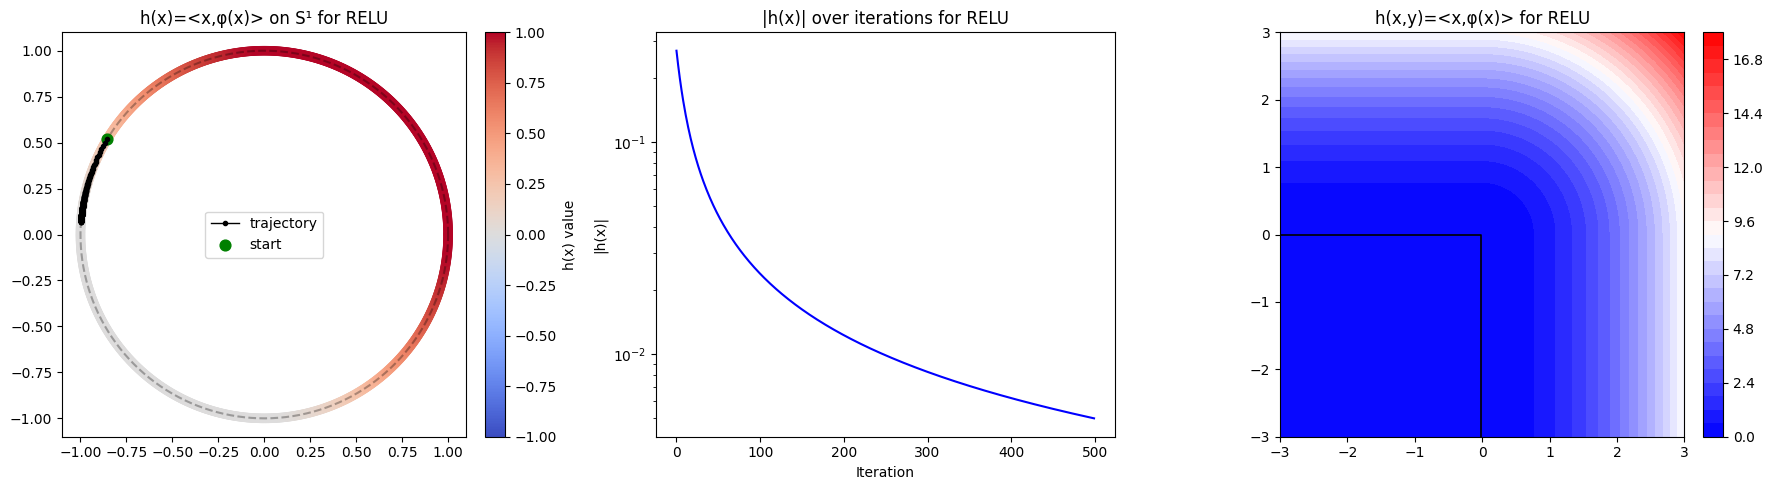

In [100]:
seed = np.random.randint(1000000)

phi, dphi = RELU, dRELU
x_star, h_val, h_hist = optimise_vanishing_set(phi=phi, dphi=dphi, n=2, seed=seed, steps=3000, lr=0.01, tol=1e-8)
print("x* on sphere:", x_star)
print("<x*, f(x*)> =", h_val)

plot_vanishing_set(phi=phi, dphi=dphi, name=phi.__name__, n_points=1000, eps=1e-8, seed=seed)

# Grid of plots

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def plot_vanishing_set_to_axes(axs_row, phi, dphi, name="activation",
                               n_points=400, eps=1e-8, seed=0):
    """
    Draws the 2 visualisations (circle view + contour) directly
    onto an existing row of axes, without creating or showing a figure.

    Parameters
    ----------
    axs_row : list[matplotlib.axes.Axes]
        Two axes for circle view and contour.
    phi, dphi : callables
        Activation function and its derivative.
    name : str
        Activation name for titles.
    """
    rng = np.random.default_rng(seed)

    # === (1) Sample h(x) on the unit circle ===
    theta = np.linspace(0, 2*np.pi, n_points)
    circle = np.c_[np.cos(theta), np.sin(theta)]
    hvals = np.array([np.dot(p, phi(p)) for p in circle])
    vmax = np.max(np.abs(hvals))

    # === (2) Optimisation (trajectory + convergence) ===
    def h(x): return float(np.dot(x, phi(x)))
    def grad_h(x): return phi(x) + dphi(x) * x
    def proj_tangent(x, v): return v - x * np.dot(x, v)
    def step_on_sphere(x, g, eta):
        y = x - eta * g
        return y / np.linalg.norm(y)

    x = rng.normal(size=2)
    x /= np.linalg.norm(x)
    start_point = x.copy()
    traj = [x.copy()]
    lr = 0.1
    for _ in range(500):
        hx = h(x)
        g_euc = grad_h(x)
        g_sph = hx * proj_tangent(x, g_euc)
        x = step_on_sphere(x, g_sph, lr)
        traj.append(x.copy())
    traj = np.array(traj)

    # === (3) Contour map ===
    xs = np.linspace(-3, 3, 200)
    ys = np.linspace(-3, 3, 200)
    X, Y = np.meshgrid(xs, ys)
    Z = X * phi(X) + Y * phi(Y)

    # ---------------------------------------------------------------------
    # (1) Circle view with trajectory
    ax1 = axs_row[0]
    ax1.plot(circle[:, 0], circle[:, 1], 'k--', alpha=0.3)
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    scatter = ax1.scatter(circle[:, 0], circle[:, 1], c=hvals,
                          cmap='coolwarm', s=35, norm=norm)
    ax1.plot(traj[:, 0], traj[:, 1], 'k.-', lw=1, label="trajectory")
    ax1.scatter(start_point[0], start_point[1], c='green', s=60, marker='o', label="start")
    ax1.set_aspect('equal')
    ax1.set_title(name, fontsize=10)
    ax1.legend(fontsize=7)

    # (2) Contour map
    ax2 = axs_row[1]
    contour = ax2.contourf(X, Y, Z, levels=30, cmap='bwr')
    ax2.contour(X, Y, Z, levels=[0], colors='k', linewidths=1.2)
    ax2.set_aspect('equal')
    ax2.set_title("h(x,y)=<x,φ(x)>", fontsize=9)

    return scatter, contour


def plot_activation_grid(activations):
    n = len(activations)
    fig, axs = plt.subplots(2, n, figsize=(4*n, 8))
    plt.subplots_adjust(wspace=0.5, hspace=-0.05)

    for j, (name, phi, dphi) in enumerate(activations):
        sc, cont = plot_vanishing_set_to_axes(axs[:, j], phi, dphi, name)

        # Add colourbars beside each plot column
        fig.colorbar(sc, ax=axs[0, j], fraction=0.046, pad=0.04)
        fig.colorbar(cont, ax=axs[1, j], fraction=0.046, pad=0.04)

    plt.savefig("c_n activation func classification.png", dpi=300, bbox_inches='tight')
    plt.show()


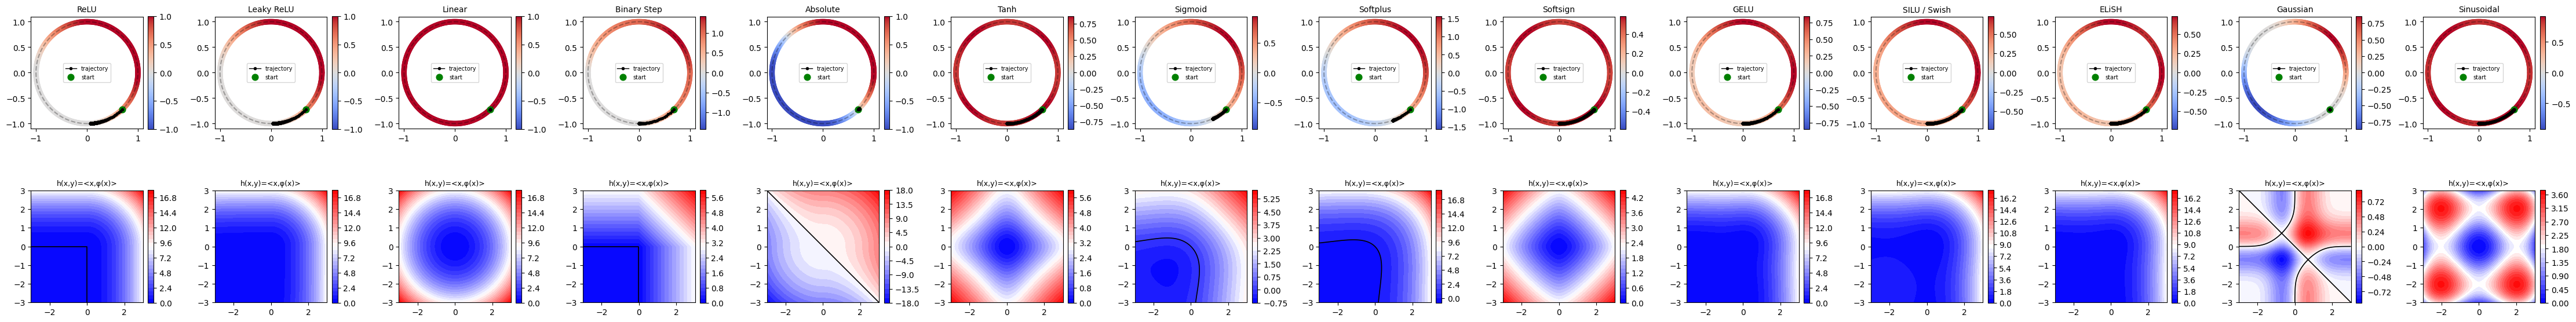

In [144]:
activations = [
    ("ReLU", RELU, dRELU),
    ("Leaky ReLU", LEAKY_RELU, dLEAKY_RELU),
    ("Linear", LINEAR, dLINEAR),
    ("Binary Step", BINARY, dBINARY),
    ("Absolute", ABS, dABS),
    ("Tanh", TANH, dTANH),
    ("Sigmoid", SIGMOID, dSIGMOID),
    ("Softplus", SOFTPLUS, dSOFTPLUS),
    ("Softsign", SOFTSIGN, dSOFTSIGN),
    ("GELU", GELU, dGELU),
    ("SILU / Swish", SILU, dSILU),
    ("ELiSH", ELISH, dELISH),
    ("Gaussian", GAUSSIAN, dGAUSSIAN),
    ("Sinusoidal", SINUSOIDAL, dSINUSOIDAL),
]
plot_activation_grid(activations)